## Customer Churn Model: Building machine learning models on Azure Databricks Managed MLflow
###### Azure-Databricks-MLops-using-MLflow: an end-to-end example

Now that we've ingested and processed our customer data, we want to understand what makes one customer more likely to churn than another, and ultimately see if we can produce a machine learning model that can accurately predict if a given customer will churn or not.

For a data science team charged with creating this model, they will usually undergo a set of key tasks: 

- Exploring data to understand the features available, any interesting patterns that can be found, and its potential for training such model
- Running tools such as a hyperparameter sweep to identify the best performing algorithm for the model
- Validating the model against the holdout dataset, and registering the model if its performance is sustained over the unseen data
- Deploying the model to production and to be used against real-world data - in this case, our full customer base to identify churn candidates and take preventive actions

###### In this notebook, build a model to predict customer churn

In [ ]:
# Requirements
%pip install --upgrade cloudpickle xgboost hyperopt mlflow azureml azure-ai-ml azureml-mlflow azureml-core azureml-sdk[databricks]

In [ ]:
#Saving some variables for later use in the notebook. These will be unique to your lab instance
databricks_token= "#DATABRICKS_TOKEN#"
workspace_model_url = '#WORKSPACE_URL#/serving-endpoints/retail-churn-endpoint/invocations'

In [ ]:
# Loading required packages
import cloudpickle
import time
import json
import numpy as np
import pandas as pd
from math import exp
import xgboost as xgb

# Loading MLflow libraries
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

# Loading packages for building a Machine Learning pipeline
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Loading packages for hyperparameter tuning
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

# Loading libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Import Data
The customer churn data is coming from Teradata (external storage) to OneLake silver layer. We are then loading customer subscription data to Azure Databricks Delta table.  

Spark SQL also includes a cost-based optimizer, columnar storage, and code generation to make queries fast. At the same time, it scales to thousands of nodes and multi-hour queries using the Spark engine, which provides full mid-query fault tolerance, without having to worry about using a different engine for historical churn data.

In [ ]:
# Loading data from OneLake (Silver layer)
spark_df = spark.read.format("delta").load("/mnt/OneLake_Silver/Tables/Tables/fact_churndata")
display(spark_df.select("*"))

CustomerID Gender SeniorCitizen Partner Dependents tenure Discount OutletSize OnlineDelivery OrderStatus CustomerSupport Brand StoreContract PaperlessBilling PaymentMethod UnitPrice TotalAmount Churn 7795-CFOCW Male 0 No No 45 No Big Yes Shipped Yes Local One year No Bank transfer (automatic) 42.3 1840.75 No 1708-PBBOA Female 0 No No 42 No Big Yes Shipped Yes Local One year Yes Electronic check 54.75 2348.45 No 0308-IVGOK Female 0 No No 11 No Big No Shipped Yes Local One year Yes Credit card (automatic) 40.4 422.6 No 9411-TPQQV Female 0 No No 40 No Big Yes Shipped Yes National One year Yes Bank transfer (automatic) 54.55 2236.2 No 5125-CNDSP Male 0 No Yes 63 No Big Yes Shipped Yes Local One year Yes Bank transfer (automatic) 40.6 2588.95 No 2316-ESMLS Female 0 Yes Yes 12 No Big Yes Shipped Yes Local One year No Credit card (automatic) 33.15 444.75 No 7876-AEHIG Female 0 No Yes 51 No Big Yes Shipped Yes National One year No Bank transfer (automatic) 60.15 3077 No 5170-PTRKA Female 0 Yes Yes 49 No Big Yes Shipped Yes Local One year Yes Credit card (automatic) 35.8 1782 No 4198-VFOEA Female 0 No No 12 No Big Yes Shipped Yes Local One year Yes Mailed check 33.6 435.45 No 1430-SFQSA Male 0 No No 29 No Big Yes Shipped Yes Local One year No Mailed check 35.6 1072.6 No 4598-ZADCK Female 0 No No 53 No Big Yes Shipped Yes National One year Yes Electronic check 53.6 2879.2 No 4730-AWNAU Male 0 Yes Yes 36 No Big Yes Shipped Yes National One year No Credit card (automatic) 60.7 2234.55 No 6682-VCIXC Female 0 Yes Yes 43 No Big Yes Shipped Yes National One year Yes Bank transfer (automatic) 51.25 2151.6 No 0121-SNYRK Male 0 No No 50 No Big Yes Shipped Yes Local One year Yes Mailed check 35.4 1748.9 No 8898-KASCD Male 0 No No 39 No Big No Shipped Yes Local One year No Mailed check 35.55 1309.15 No 7338-ERIVA Male 0 No Yes 39 No Big Yes Shipped Yes National One year No Bank transfer (automatic) 45.05 1790.6 No 4999-IEZLT Male 0 No No 66 No Big No Shipped Yes Local One year No Credit card (automatic) 29.45 1983.15 No 2361-FJWNO Male 0 No No 40 No Big No Shipped Yes Local One year No Credit card (automatic) 36 1382.9 No 6114-TCFID Female 0 No No 29 No Big Yes Shipped Yes Local One year No Credit card (automatic) 39.5 1082.75 No 3275-RHRNE Male 0 Yes Yes 28 No Big No Shipped Yes National One year Yes Credit card (automatic) 60 1682.05 No 8314-DPQHL Male 0 No No 9 No Big Yes Shipped Yes Local One year No Mailed check 50.8 463.6 No 2606-PKWJB Male 0 No Yes 40 No Big Yes Shipped Yes Local One year No Mailed check 40.25 1564.05 No 5199-FPUSP Male 0 No Yes 33 No Big Yes Shipped Yes Local One year No Credit card (automatic) 34.05 1113.95 No 4702-HDRKD Male 0 No No 67 No Big Yes Shipped Yes National One year Yes Bank transfer (automatic) 49.35 3321.35 No 3181-VTHOE Male 0 Yes No 70 No Big No Shipped Yes Local One year Yes Bank transfer (automatic) 51.05 3635.15 No 4825-XJGDM Female 0 No No 61 No Big Yes Shipped Yes Local One year No Credit card (automatic) 43.7 2696.55 No 1301-LOPVR Male 0 Yes Yes 29 No Big Yes Shipped Yes Local One year Yes Credit card (automatic) 55.35 1636.95 No 2292-XQWSV Male 0 Yes Yes 40 No Big No Shipped Yes National One year No Mailed check 60.3 2448.5 No 8328-SKJNO Male 0 No Yes 23 No Big Yes Shipped Yes Local One year No Bank transfer (automatic) 40.65 947.4 No 1729-VLAZJ Female 0 No Yes 10 No Big Yes Shipped Yes Local One year No Mailed check 40.25 411.45 No 9955-QOPOY Male 0 Yes No 69 No Big No Shipped Yes National One year Yes Credit card (automatic) 60.8 4263.4 No 1866-DIOQZ Female 0 Yes No 71 No Big Yes Shipped Yes National One year No Bank transfer (automatic) 66.8 4689.15 No 4654-GGUII Female 0 No No 18 No Big Yes Shipped Yes Local One year Yes Mailed check 40.2 711.95 No 2073-QBVBI Female 0 Yes No 41 No Big No Shipped Yes Local One year No Mailed check 35.45 1391.65 No 6229-UOLQL Male 0 Yes Yes 56 No Big Yes Shipped Yes National One year Yes Mailed check 52 2884.9 No 7325-ENZFI Female 0 No No 39 No Big Yes Shipped Yes 

#### Data Preparation

Databricks DataFrames can easily be converted to the popular Pandas dataframes. With [Pandas on Spark](https://learn.microsoft.com/en-us/azure/databricks/languages/pandas-spark) you can even leverage the same Pandas code you know and love with Spark APIs for processing large datasets. Here we have used Pandas to quickly clean our input dataset further by removing errors, null values, and adjusting inconsistent column values.

In [ ]:
# convert to pandas
df = spark_df.toPandas()
# dropping customer ids from df
df.drop('CustomerID', axis=1, inplace=True)

# Convert datatypes as required
df['TotalAmount'] = pd.to_numeric(df['TotalAmount'], errors="coerce")
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors="coerce")
df['tenure'] = pd.to_numeric(df['tenure'], errors="coerce")
#df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='Male' else 1)
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 'No' if x==0 else 'Yes')

# remove rows with null value in Total Amount
df.drop(df[df['TotalAmount'].isnull()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

#### Exploratory Data Analysis
Exploratory Data Analysis (EDA) ensures the readiness of the data for Machine Learning and ensures that the data is more usable. Without proper EDA, Machine Learning algorithms might not perform as expected.it is the initial process of examining and understanding a dataset through summary statistics, visualizations, and data exploration techniques.

Below graph explain that customers who are spending less amount and have short term relationship, have high chances to became Churn.

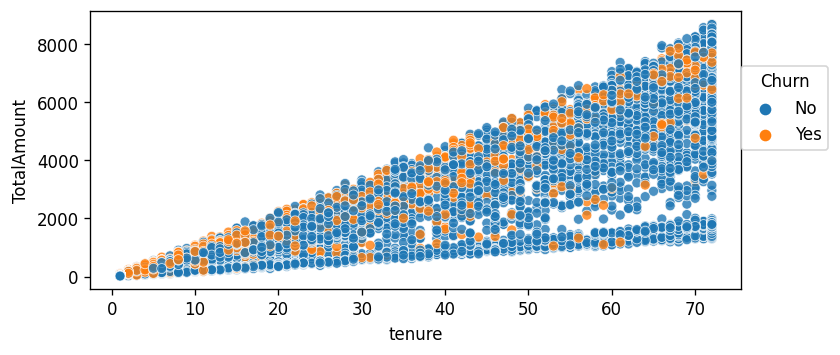

In [ ]:
# Churn rate with tenure and Total amount spend
plt.figure(figsize=(7,3),dpi=120)
sns.scatterplot(data=df,x='tenure',y='TotalAmount',hue='Churn',alpha=0.8)
plt.legend(loc=(1,0.5),title = "Churn")

Feature correlation measures the relationship between variables in a dataset, revealing patterns and dependencies for analysis and decision-making.

Below graph explain that, the correlation between other factors influencing customer churn such as Online Delivery, Payment Methods, Customer Support, etc.

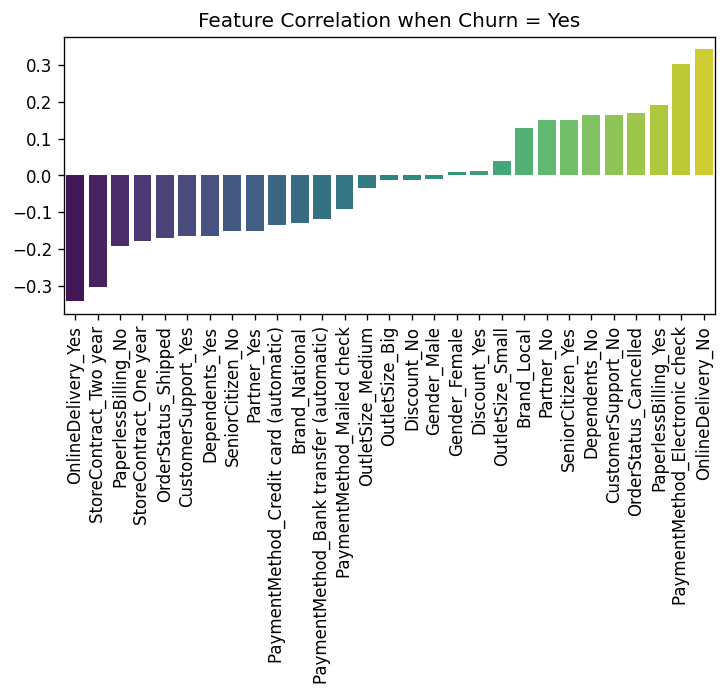

In [ ]:
# Feature Correlation
df_corr  = pd.get_dummies(df[['Gender', 'SeniorCitizen', 'Partner', 'Dependents','Discount', 'OutletSize', 'OnlineDelivery',
       'OrderStatus', 'CustomerSupport', 'Brand', 'StoreContract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

# Feature Correlation when Churn = Yes
plt.figure(figsize=(7,3),dpi=120)
sns.barplot(x=df_corr['Churn_Yes'].sort_values().iloc[1:-2].index,y=df_corr['Churn_Yes'].sort_values().iloc[1:-2].values,palette='viridis')
plt.title('Feature Correlation when Churn = Yes')
plt.xticks(rotation=90);

#### Split data
Prior to training a model, split the data into training and testing sets.

Prepare dataset for training baseline model Split the input data into 2 sets: 
- Train (75% of the dataset used to train the model) 
- Test (25% of the dataset used to report the true performance of the model on an unseen dataset)

In [ ]:
# Encoding churn as 0 and 1, Churn = 1 and Not churn = 0
df['Churn'] = df['Churn'].apply(lambda x: 0 if x=='No' else 1)

# separating dependent and independent variables
X= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int64')
y= df['Churn']

# Split out the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Build a baseline model

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model metrics, and to save the model for later use.
Train a classifier within the context of an MLflow run, which automatically logs the trained model and many associated metrics and parameters. 

You can supplement the logging with additional metrics such as the model's AUC score on the test dataset.

In [ ]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='base_churn_model'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("base_churn_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)
  

2023/07/03 13:33:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/databricks/python/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integ

Feature importance refers to the assessment of the impact of each feature in a dataset towards a target column. It helps to identify the most influential features in predicting the target variable and guides feature selection or prioritization for modeling and decision-making purposes.

In [ ]:
# check feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False).head()

importance
TotalAmount                       0.204211
UnitPrice                         0.201860
tenure                            0.188588
OnlineDelivery_Yes                0.059300
PaymentMethod_Electronic check    0.031964

#### Register the model in MLflow Model Registry
By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.
The following section shows how to do this programmatically, but you can also register a model using the UI.

In [ ]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "base_churn_model"').iloc[0].run_id
run_id

'4b4f0f2ff88b4933b286ea5907456cb7'

In [ ]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "retail_churn_model". Try using a different name.
import mlflow
model_name = "retail_churn_model"
model_version = mlflow.register_model(f"runs:/{run_id}/base_churn_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'retail_churn_model' already exists. Creating a new version of this model...
2023/07/03 13:33:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: retail_churn_model, version 7
Created version '7' of model 'retail_churn_model'.


In [ ]:
# Transition a model version to a different stage
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

<ModelVersion: aliases=[], creation_timestamp=1688391224541, current_stage='Production', description='', last_updated_timestamp=1688391245948, name='retail_churn_model', run_id='4b4f0f2ff88b4933b286ea5907456cb7', run_link='', source='dbfs:/databricks/mlflow-tracking/977241199424904/4b4f0f2ff88b4933b286ea5907456cb7/artifacts/base_churn_model', status='READY', status_message='', tags={}, user_id='1258158786798171', version='7'>

In [ ]:
# Load a model stored in Python function format
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

2023/07/03 13:34:07 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - cloudpickle (current: 2.2.1, required: cloudpickle==2.0.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


AUC: 0.7968661319964325


#### Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [ ]:
X= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int32')
y= df['Churn']

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)
 
# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [ ]:
# Hyperparameters  
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}
 
def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)
 
    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "final_model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='final_churn_model'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=50,
    trials=spark_trials,
  )

100%|██████████| 50/50 [02:09<00:00,  2.60s/trial, best loss: -0.8357521576407068]


Total Trials: 50: 50 succeeded, 0 failed, 0 cancelled.


#### Search runs to retrieve the best model
Because all of the runs are tracked by MLflow, you can retrieve the metrics and parameters for the best run using the MLflow search runs API to find the tuning run with the highest test AUC.

This tuned model should perform better than the simpler models trained in Part 1. 
The code finds the best performing run and saves the model-to-Model Registry. In this case, AUC is a primary metric, and the best-performing model is selected for production deployment. If the latest model performs better than earlier deployed models, the new model is deployed to the production environment and the old model gets archived. If the latest model gives a lesser AUC score, then the previously deployed model remains in the production environment.

In [ ]:
# Sort runs by their test AUC; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.auc"]))
print('Best Iteration: {}'.format(best_run["metrics.best_iteration"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))

Best Run
AUC: 0.806071815690445
Best Iteration: 17.0
Max Depth: 72
Learning Rate: 0.1090890967565803


#### Compare multiple runs in the UI
As in Part 1, you can view and compare the runs in the MLflow experiment details page, accessible via the external link icon at the top of the **Experiment** sidebar. 

On the experiment details page, click the "+" icon to expand the parent run, then select all runs except the parent, and click **Compare**. You can visualize the different runs using a parallel coordinates plot, which shows the impact of different parameter values on a metric. 

<img width="500" src="https://docs.databricks.com/_static/images/mlflow/quickstart/parallel-plot.png"/>

#### Register new model in the Model Registry

In [ ]:
# best run model version
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/final_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'retail_churn_model' already exists. Creating a new version of this model...
2023/07/03 13:36:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: retail_churn_model, version 8
Created version '8' of model 'retail_churn_model'.


In [ ]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)
 
# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1688391379160, current_stage='Production', description='', last_updated_timestamp=1688391400689, name='retail_churn_model', run_id='92e8a4331ae74e1bb99b991a4affb911', run_link='', source='dbfs:/databricks/mlflow-tracking/977241199424904/92e8a4331ae74e1bb99b991a4affb911/artifacts/final_model', status='READY', status_message='', tags={}, user_id='1258158786798171', version='8'>

#### Load models
You can also access the results for a specific run using the MLflow API. The code in the following cell illustrates how to load the model trained in a given MLflow run and use it to make predictions.

In [ ]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

2023/07/03 13:36:41 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


AUC: 0.8114011311214784


#### Model Serving in Databricks Workspace
To productionize the model for low latency predictions, use MLflow Model Serving to deploy the model to an endpoint.

The following code illustrates how to issue requests using a REST API to get predictions from the deployed model.

**Note**: You need a Databricks token to issue requests to your model endpoint. You can generate a token from the User Settings page.

In [ ]:
import os
os.environ["DATABRICKS_TOKEN"] = databricks_token

### Enable Serving
Click Models in the left sidebar and navigate to the registered wine model. Click the serving tab, and then click Enable Serving.

Then, under Call The Model, click the Python button to display a Python code snippet to issue requests. Copy the code into this notebook. It should look similar to the code in the next cell.

######You can use the token to make these requests from outside Databricks notebooks as well.

In [ ]:
# scoring script to predict churn from deployed model
import os
import requests
import numpy as np
import pandas as pd
import json

def create_tf_serving_json(data):
    return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
    url = workspace_model_url
    headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}', 
'Content-Type': 'application/json'}
    ds_dict = {'dataframe_split': dataset.to_dict(orient='split')} if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
    data_json = json.dumps(ds_dict, allow_nan=True)
    response = requests.request(method='POST', headers=headers, url=url, data=data_json)
    if response.status_code != 200:
        raise Exception(f'Request failed with status {response.status_code}, {response.text}')
    
    return response.json()

### Model Prediction
Predicting probability of customer churn using deployed model (served_predictions) and best run trained model (model_evaluations). If we get same probability means the model got deployed successfully and is ready to use this model endpoint for production.

In [ ]:
# Model serving is designed for low-latency predictions on smaller batches of data
data_for_pred= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int32')

adb_response = score_model(data_for_pred)

# Results from the deployed model
adb_prediction = pd.DataFrame.from_dict(adb_response)

adb_prediction['PredictedChurn'] = adb_prediction['predictions'].apply(lambda x: 'Yes' if x>=0.50 else "No")
adb_prediction

adb_result = pd.concat( [df, adb_prediction], axis=1) 

# create Spark DataFrame
adb_result_spark = spark.createDataFrame(adb_result)
display(adb_result_spark)

In [ ]:
# Store data into Gold Layer as a Delta Perquet format
adb_result_spark.write.mode("overwrite").format("delta").save("/mnt/OneLake_Gold/Tables/Tables/ml_predicted_customer_churn_data") 

In [ ]:
# Ending mlflow season
mlflow.end_run()

# Sales Forecasting

Once we have run our campaign, we use Sklearn Regression model, operationalized using MLflow and Azure ML, to predict total sales revenue using the post campaign data. We are using the following features: 
- Store (Store Identifier Number)
- Brand (The brand of the product)
- Quantity (Quantity of product purchased)
- Advert (Whether the product had an advertisement or not)
- Price (How much the product costs)

## Pre-requisite
### Run this cell to load the required data into the table

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
#import azureml
#import azureml.core
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.spark
#import mlflow.azureml
from mlflow.deployments import get_deploy_client
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from pyspark.ml.feature import StringIndexer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.types import *
from azureml.core import Workspace
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes
from azure.identity import DeviceCodeCredential

%matplotlib inline

## Load the Dataset from table

In [ ]:
# Loading train data from OneLake (Silver layer)
train = spark.read.format("delta").load("/mnt/OneLake_Silver/Tables/Tables/dlt_silver_train")
# select the columns
train = train.select(train.columns[2:8])
train.show(5)

# Loading test data from OneLake (Silver layer)
test = spark.read.format("delta").load("/mnt/OneLake_Silver/Tables/Tables/dlt_silver_test")
# select the columns
test = test.select(test.columns[2:8])
test.show(5)

+-----+------+--------+------+-----+--------+
|Store| Brand|Quantity|Advert|Price| Revenue|
+-----+------+--------+------+-----+--------+
| 1384|BrandB|   15577|     1| 2.57|40032.89|
| 1384|BrandC|   14299|     1| 2.31|33030.69|
| 1385|BrandA|   18282|     1| 2.06|37660.92|
| 1385|BrandB|   13702|     1| 2.04|27952.08|
| 1385|BrandC|   14535|     1| 1.97|28633.95|
+-----+------+--------+------+-----+--------+
only showing top 5 rows

+-----+------+--------+------+-----+--------+
|Store| Brand|Quantity|Advert|Price| Revenue|
+-----+------+--------+------+-----+--------+
| 1384|BrandA|   12939|     1| 2.14|27689.46|
| 1384|BrandB|   18022|     1|  2.5| 45055.0|
| 1384|BrandC|   10733|     1|  2.0| 21466.0|
| 1385|BrandA|   15884|     1| 2.04|32403.36|
| 1385|BrandB|   11356|     1| 2.27|25778.12|
+-----+------+--------+------+-----+--------+
only showing top 5 rows



## Assign column types

In [ ]:
train=train.withColumn("Store",train.Store.cast(StringType()))
train=train.withColumn("Revenue",train.Revenue.cast(DoubleType()))
train=train.withColumn("Price",train.Price.cast(DoubleType()))
train=train.withColumn("Advert",train.Advert.cast(BooleanType()))
train=train.withColumn("Quantity",train.Quantity.cast(DoubleType()))

test=test.withColumn("Store",test.Store.cast(StringType()))
test=test.withColumn("Revenue",test.Revenue.cast(DoubleType()))
test=test.withColumn("Price",test.Price.cast(DoubleType()))
test=test.withColumn("Advert",test.Advert.cast(BooleanType()))
test=test.withColumn("Quantity",test.Quantity.cast(DoubleType()))

## Convert Brand to categorical column

In [ ]:
catCols = ["Brand"]
trainCat = train
testCat = test
for catCol in catCols:
    simodel = StringIndexer(inputCol=catCol, outputCol=catCol + "_numeric", handleInvalid='keep').fit(train)
    trainCat = (
        simodel.transform(trainCat)
        .drop(catCol)
        .withColumnRenamed(catCol + "_numeric", catCol)
    )
    testCat = (
        simodel.transform(testCat)
        .drop(catCol)
        .withColumnRenamed(catCol + "_numeric", catCol)
    )
    
display(trainCat)

## Create feature and label datasets

In [ ]:
#Setup Test/Train datasets
train_df = trainCat.toPandas()
test_df = testCat.toPandas()
test_df = test_df.dropna()

#Separate them into features and label datasets
train_x = train_df.drop(["Store", "Revenue"], axis=1)
train_y = train_df[["Revenue"]]

test_x = test_df.drop(["Store", "Revenue"], axis=1)
test_y = test_df[["Revenue"]]

In [ ]:
resultsPdf = pd.DataFrame()
experimentName = "sales-forecasting"

with mlflow.start_run(run_name='sales_forecasting'):
    mlflow.sklearn.autolog()
    # Fit, train, and score the model
    model = RandomForestRegressor(max_depth = 2, n_estimators = 100)
    model.fit(train_x, train_y)
    preds = model.predict(test_x)

    # Get Metrics
    mse = mean_squared_error(test_y, preds)
    r2 = r2_score(test_y, preds)

    # Log Metrics and Model
    mlflow.log_metric('mse', mse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(model, "model")

    # Build Metrics Table
    results = [[mse, r2]]
    runResultsPdf = pd.DataFrame(results, columns =['MSE', 'r2'])
    resultsPdf = resultsPdf.append(runResultsPdf)
    
    #Log the model and get run id
    mlflow.sklearn.log_model(model, experimentName)
    run_id = mlflow.active_run().info.run_id
  
resultsPdf

/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_sklearn.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  original_result = original(self, *args, **kwargs)
<command-977241199424960>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsPdf = resultsPdf.append(runResultsPdf)


MSE        r2
0  1.379361e+07  0.786475

## Save, load, or score the Regressor on the test data

In [ ]:
model_uri = "runs:/"+run_id+"/model"

#Create a Spark UDF for the MLFlow model
pyfunc_udf = mlflow.pyfunc.spark_udf(spark, model_uri)

#Load Scoring Data into Spark Dataframe
scoreDf = testCat

#Make Prediction
preds = (scoreDf
           .withColumn('Revenue-prediction', pyfunc_udf("Quantity", "Advert", "Price", "Brand"))
        )
display(preds)
## Registering the model in Mlflow


2023/07/03 13:46:05 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.
2023/07/03 13:46:06 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


Store Quantity Advert Price Revenue Brand Revenue-prediction 1384 12939 true 2.140000104904175 27689.4609375 0 29953.553974342994 1384 18022 true 2.5 45055 1 42846.661996362294 1384 10733 true 2 21466 2 23731.364639001786 1385 15884 true 2.0399999618530273 32403.359375 0 36013.97724859733 1385 11356 true 2.2699999809265137 25778.119140625 1 23731.364639001786 1385 15224 true 1.899999976158142 28925.599609375 2 36013.97724859733 1386 15284 true 1.9900000095367432 30415.16015625 0 36013.97724859733 1386 17975 true 1.9500000476837158 35051.25 1 36013.97724859733 1386 12936 true 2 25872 2 29953.553974342994 1387 11398 true 2.390000104904175 27241.220703125 0 23731.364639001786 1387 14386 true 2.369999885559082 34094.8203125 1 36791.355818957614 1387 19618 true 1.909999966621399 37470.37890625 2 36013.97724859733 1388 9836 true 1.9600000381469727 19278.560546875 0 23731.364639001786 1388 11468 true 1.909999966621399 21903.880859375 1 23731.364639001786 1388 19286 true 2.2799999713897705 43972.078125 2 37863.18514858056 1389 14775 true 2.5799999237060547 38119.5 0 42846.661996362294 1389 15827 true 2.119999885559082 33553.23828125 1 36013.97724859733 1389 10251 true 2.2200000286102295 22757.220703125 2 23731.364639001786 138 9135 true 2.430000066757202 22198.05078125 0 23731.364639001786 138 13746 true 2.490000009536743 34227.5390625 1 29953.553974342994 138 13545 true 2.390000104904175 32372.55078125 2 29953.553974342994 1390 13327 true 2.5399999618530273 33850.578125 0 29953.553974342994 1390 19860 true 2.119999885559082 42103.19921875 1 36013.97724859733 1390 15070 true 2.4000000953674316 36168 2 42846.661996362294 1391 17028 true 2.630000114440918 44783.640625 0 42846.661996362294 1391 12195 true 2.4800000190734863 30243.599609375 1 29953.553974342994 1391 12595 true 1.9299999475479126 24308.349609375 2 29953.553974342994 1392 11615 true 2.2799999713897705 26482.19921875 0 23731.364639001786 1392 17720 true 2.140000104904175 37920.80078125 1 36013.97724859733 1392 14371 true 2.049999952316284 29460.55078125 2 33182.25218824746 1393 16941 true 2.2899999618530273 38794.890625 0 38615.229070087844 1393 12453 true 2.119999885559082 26400.359375 1 29953.553974342994 1393 15719 true 2.3399999141693115 36782.4609375 2 42846.661996362294 1394 19828 true 1.940000057220459 38466.3203125 0 36013.97724859733 1394 9125 true 2.240000009536743 20440 1 23731.364639001786 1394 14348 true 2.200000047683716 31565.599609375 2 32144.13623223223 1395 17493 true 2.1700000762939453 37959.80859375 0 36013.97724859733 1395 15056 true 2.1500000953674316 32370.400390625 1 36013.97724859733 1395 18911 true 2.369999885559082 44819.0703125 2 42846.661996362294 1396 18073 true 2.2899999618530273 41387.171875 0 38615.229070087844 1396 19857 true 2.359999895095825 46862.51953125 1 42846.661996362294 1396 14075 true 1.909999966621399 26883.25 2 29953.553974342994 1397 9977 true 2.109999895095825 21051.470703125 0 23731.364639001786 1397 9414 true 2.109999895095825 19863.5390625 1 23731.364639001786 1397 12014 true 2.059999942779541 24748.83984375 2 29953.553974342994 1398 13951 true 1.909999966621399 26646.41015625 0 29953.553974342994 1398 13947 true 2.6600000858306885 37099.01953125 1 29953.553974342994 1398 18664 true 1.9299999475479126 36021.51953125 2 36013.97724859733 1399 9663 true 2.3399999141693115 22611.419921875 0 23731.364639001786 1399 16300 true 2.259999990463257 36838 1 36013.97724859733 1399 10300 true 2.0899999141693115 21527 2 23731.364639001786 139 13264 true 2.4600000381469727 32629.439453125 0 29953.553974342994 139 16818 true 2.3499999046325684 39522.30078125 1 42846.661996362294 139 14546 true 2.0899999141693115 30401.140625 2 35896.062498575775 1400 13799 true 1.9600000381469727 27046.0390625 0 29953.553974342994 1400 14712 true 2 29424 1 36013.97724859733 1400 16679 true 2.190000057220459 36527.01171875 2 36013.97724859733 1401 19524 true 2.4600000381469727 48029.0390625 0 42846.661996362294 1401 18733 true 1.909999966621399 35780.03125 1

## Registering the model in MLflow model registry

In [ ]:
# model name
model_name = "sales_forecasting"

#Register the model
model_version = mlflow.register_model("runs:/"+run_id+"/model", model_name)

Registered model 'sales_forecasting' already exists. Creating a new version of this model...
2023/07/03 13:46:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sales_forecasting, version 2
Created version '2' of model 'sales_forecasting'.


## Fetching predictions from the endpoint

In [ ]:
#First we need to fetch data from after the campaign in order to make a sales forecast
schema = StructType([
    StructField("Quantity", DoubleType()),
    StructField("Advert", IntegerType()),
    StructField("Price", FloatType()),
    StructField("Brand", StringType())
])

predicted_df = spark.read.format("csv").option("header",True).schema(schema).load('/mnt/datasource-onelake-bronze/StoreTransactionsData/SalesDataAfterCampaign.csv').toPandas()
predicted_df.head()

Quantity  Advert  Price Brand
0   11225.0       1   2.47     0
1   10225.0       1   2.30     1
2   11365.0       1   2.27     0
3   13315.0       0   2.17     0
4   14317.0       1   2.67     1

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import json

def create_tf_serving_json(data):
    return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
    url = '#WORKSPACE_URL#/serving-endpoints/sales-forecasting-endpoint/invocations'
    headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}', 
'Content-Type': 'application/json'}
    ds_dict = {'dataframe_split': dataset.to_dict(orient='split')} if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
    data_json = json.dumps(ds_dict, allow_nan=True)
    response = requests.request(method='POST', headers=headers, url=url, data=data_json)
    if response.status_code != 200:
        raise Exception(f'Request failed with status {response.status_code}, {response.text}')

    return response.json()

In [ ]:
# Model serving is designed for low-latency predictions on smaller batches of data
predicted_df['Advert'] = predicted_df['Advert'].astype(float)
predicted_df = predicted_df.dropna()

# get forecasting
adb_response = score_model(predicted_df)

# Results from the deployed model
adb_prediction = pd.DataFrame.from_dict(adb_response)
adb_prediction.rename(columns = {'predictions':'Predicted_Revenue'}, inplace = True)

predicted_sales = pd.concat( [predicted_df, adb_prediction], axis=1)
predicted_sales.head() 

Quantity  Advert  Price Brand  Predicted_Revenue
0   11225.0     1.0   2.47     0       23725.693026
1   10225.0     1.0   2.30     1       23725.693026
2   11365.0     1.0   2.27     0       23725.693026
3   13315.0     0.0   2.17     0       29942.812043
4   14317.0     1.0   2.67     1       32000.329552

## Visualize predicted sales revenue

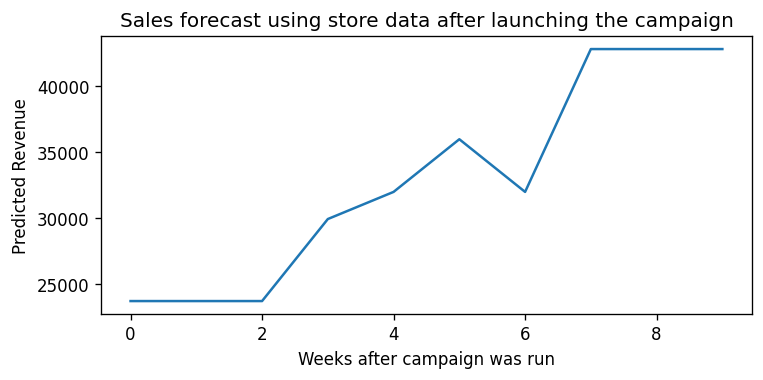

In [ ]:
plt.figure(figsize=(7,3),dpi=120)
ax =sns.lineplot(data=predicted_sales['Predicted_Revenue'])
plt.title('Sales forecast using store data after launching the campaign')
ax.set(xlabel='Weeks after campaign was run',ylabel="Predicted Revenue")
sns.set(style='darkgrid',palette='pastel')
plt.show()

## Writing predictions to OneLake for further use

In [ ]:
spark_df= spark.createDataFrame(predicted_sales)
spark_df.show()

+--------+------+-----+-----+------------------+
|Quantity|Advert|Price|Brand| Predicted_Revenue|
+--------+------+-----+-----+------------------+
| 11225.0|   1.0| 2.47|    0| 23725.69302643081|
| 10225.0|   1.0|  2.3|    1| 23725.69302643081|
| 11365.0|   1.0| 2.27|    0| 23725.69302643081|
| 13315.0|   0.0| 2.17|    0| 29942.81204255978|
| 14317.0|   1.0| 2.67|    1|32000.329551845785|
| 17325.0|   1.0| 2.11|    2| 35991.06856713108|
| 14317.0|   1.0| 2.67|    1|32000.329551845785|
| 17129.0|   1.0| 2.81|    0|42826.366992441595|
| 19064.0|   0.0| 2.99|    0|42826.366992441595|
| 23064.0|   0.0| 2.92|    1|42826.366992441595|
+--------+------+-----+-----+------------------+



In [ ]:
spark_df.write.mode("overwrite").format("delta").save("/mnt/OneLake_Gold/Tables/Tables/ml_sales_forecasting") 
mlflow.end_run()